# Summary

<ul>
<li>1. Importing Libraries</li>
<li>2. Analyzing Data From Toronto, Canada</li>
    <ul>
        <li>2.1 Scrapping Wikipedia Page</li>
        <li>2.2 Retrieving latitude and longitude from postal code</li>
        <li>2.3 Exploring and clustering the neighborhoods in Toronto</li>
            <ul>
                <li>2.3.1 Analyzing Each Neighborhood</li>
                <li>2.3.2 Cluster Neighborhood</li>
            </ul>
    </ul>
<li>3. Analyzing Data New York City, USA</li>
    <ul>
        <li>3.1 Download and Explore Dataset</li>
        <li>3.2 Exploring and clustering the neighborhoods in New York City</li>
            <ul>
                <li>3.3.1 Analyzing Each Neighborhood</li>
                <li></li>
            </ul>
    </ul>
</ul>

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import Image
import json

# 2. Analyzing Data From Toronto, Canada

## 2.1 Scrapping Wikipedia Page

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Getting html from wiki page and create soup object
source = requests.get(url)
beautiful_soup = BeautifulSoup(source.text, 'lxml')

#using soup object, iterate the .wikitable to get the data from the HTML page and store it into a list
data = []
columns = []
table = beautiful_soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    input_section = []
    for td in tr.find_all(['th','td']):
        input_section.append(td.text.rstrip())
    
    #First row of data is the header
    if (index == 0):
        columns = input_section
    else:
        data.append(input_section)

In [3]:
#Converting lists into Pandas DataFrame, ignoring Not assigned Borough
dataset_toronto = pd.DataFrame(data = data,columns = columns)
dataset_toronto = dataset_toronto[dataset_toronto['Borough'] != 'Not assigned']
dataset_toronto = dataset_toronto.reset_index(drop=True)
dataset_toronto.head(12)

Postal Code           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M7A  Downtown Toronto   
5          M9A         Etobicoke   
6          M1B       Scarborough   
7          M3B        North York   
8          M4B         East York   
9          M5B  Downtown Toronto   
10         M6B        North York   
11         M9B         Etobicoke   

                                         Neighborhood  
0                                           Parkwoods  
1                                    Victoria Village  
2                           Regent Park, Harbourfront  
3                    Lawrence Manor, Lawrence Heights  
4         Queen's Park, Ontario Provincial Government  
5             Islington Avenue, Humber Valley Village  
6                                      Malvern, Rouge  
7                                           Don Mills  
8                     Parkview Hill, Woodbine Gardens  
9                            Garden District, Ryerson  
10                                          Glencairn  
11  West Deane Park, Princess Gardens, Martin Grov...

In [4]:
dataset_toronto.shape

(103, 3)

## 2.2 Retrieving latitude and longitude from postal code

In [5]:
dataset_toronto['Latitude'] = 0
dataset_toronto['Longitude'] = 0

# Using the csv file with coordinates as the geocoder library didn't work for me.
geospatial_coordinates = pd.read_csv('Geospatial_Coordinates.csv')
print(geospatial_coordinates.shape)
geospatial_coordinates.head()

(103, 3)


Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [6]:
#Retrieving Latitude and Longitude from geospatial_coordinates dataset.
index = 0
for postal_code in dataset_toronto['Postal Code']:    
    lat_lon = geospatial_coordinates[geospatial_coordinates['Postal Code'] == postal_code]
    dataset_toronto.loc[index, 'Latitude'] = lat_lon['Latitude'].iloc[0]
    dataset_toronto.loc[index, 'Longitude'] = lat_lon['Longitude'].iloc[0]
    index += 1

In [7]:
dataset_toronto.head(12)

Postal Code           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M7A  Downtown Toronto   
5          M9A         Etobicoke   
6          M1B       Scarborough   
7          M3B        North York   
8          M4B         East York   
9          M5B  Downtown Toronto   
10         M6B        North York   
11         M9B         Etobicoke   

                                         Neighborhood   Latitude  Longitude  
0                                           Parkwoods  43.753259 -79.329656  
1                                    Victoria Village  43.725882 -79.315572  
2                           Regent Park, Harbourfront  43.654260 -79.360636  
3                    Lawrence Manor, Lawrence Heights  43.718518 -79.464763  
4         Queen's Park, Ontario Provincial Government  43.662301 -79.389494  
5             Islington Avenue, Humber Valley Village  43.667856 -79.532242  
6                                      Malvern, Rouge  43.806686 -79.194353  
7                                           Don Mills  43.745906 -79.352188  
8                     Parkview Hill, Woodbine Gardens  43.706397 -79.309937  
9                            Garden District, Ryerson  43.657162 -79.378937  
10                                          Glencairn  43.709577 -79.445073  
11  West Deane Park, Princess Gardens, Martin Grov...  43.650943 -79.554724

## 2.3 Exploring and clustering the neighborhoods in Toronto

Let's get the geographical coordinates of Toronto.

In [8]:
# Using hardcoded latitude and longitude as the Geocoder library timed out on the request.
latitude = 43.6532
longitude = -79.3832
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6532, -79.3832.


Creating a map of Toronto with neighborhoods superimposed on top.

In [9]:
# create map of Toronto using latitude and longitude values
import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dataset_toronto['Latitude'], dataset_toronto['Longitude'], dataset_toronto['Borough'], dataset_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

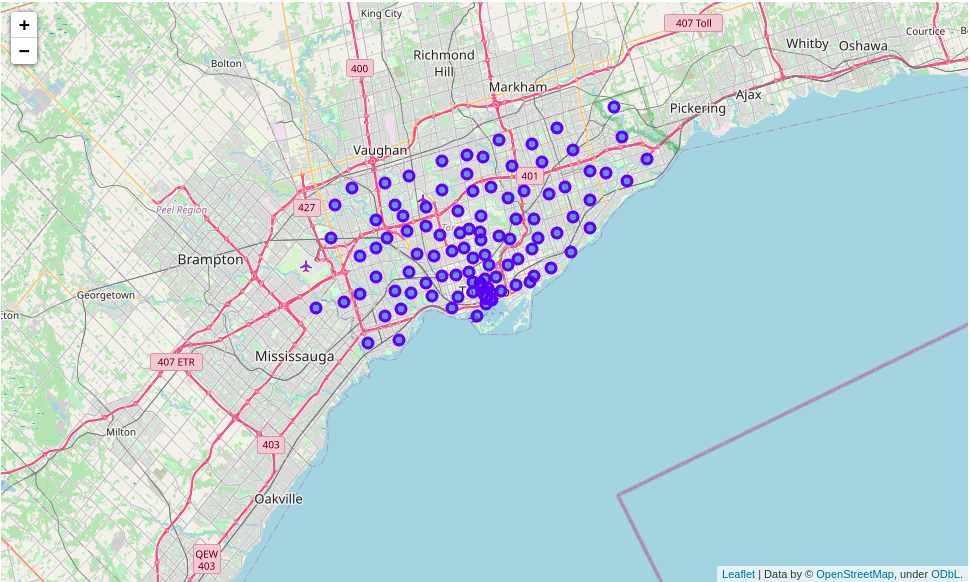

In [10]:
Image("map_toronto_0.png")

Defining Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'K5GZUIMJ0ZZLWFHJSTN25NDPT13M51F40F5TLVIBOENLUGO1' # your Foursquare ID
CLIENT_SECRET = 'YZGOHLD0QMMTOVL5QETQVN4I2WHNIURFRVRGYOXYH4304X55' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K5GZUIMJ0ZZLWFHJSTN25NDPT13M51F40F5TLVIBOENLUGO1
CLIENT_SECRET:YZGOHLD0QMMTOVL5QETQVN4I2WHNIURFRVRGYOXYH4304X55


Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [12]:
LIMIT = 30 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
dataset_toronto = dataset_toronto[dataset_toronto['Borough'].str.contains("Toronto")]
dataset_toronto = dataset_toronto.reset_index(drop=True)
print(dataset_toronto.shape)
dataset_toronto.head()

(39, 5)


Postal Code           Borough                                 Neighborhood  \
0         M5A  Downtown Toronto                    Regent Park, Harbourfront   
1         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
2         M5B  Downtown Toronto                     Garden District, Ryerson   
3         M5C  Downtown Toronto                               St. James Town   
4         M4E      East Toronto                                  The Beaches   

    Latitude  Longitude  
0  43.654260 -79.360636  
1  43.662301 -79.389494  
2  43.657162 -79.378937  
3  43.651494 -79.375418  
4  43.676357 -79.293031

In [14]:
toronto_venues = getNearbyVenues(names=dataset_toronto['Neighborhood'],
                                 latitudes=dataset_toronto['Latitude'],
                                 longitudes=dataset_toronto['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


Let's check the size of the resulting dataframe

In [15]:
print(toronto_venues.shape)
toronto_venues.head()

(868, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront               43.65426              -79.360636   
1  Regent Park, Harbourfront               43.65426              -79.360636   
2  Regent Park, Harbourfront               43.65426              -79.360636   
3  Regent Park, Harbourfront               43.65426              -79.360636   
4  Regent Park, Harbourfront               43.65426              -79.360636   

                    Venue  Venue Latitude  Venue Longitude  \
0        Roselle Desserts       43.653447       -79.362017   
1           Tandem Coffee       43.653559       -79.361809   
2      Morning Glory Cafe       43.653947       -79.361149   
3  Cooper Koo Family YMCA       43.653249       -79.358008   
4     Body Blitz Spa East       43.654735       -79.359874   

        Venue Category  
0               Bakery  
1          Coffee Shop  
2       Breakfast Spot  
3  Distribution Center  
4                  Spa

Let's check how many venues were returned for each neighborhood

In [16]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Berczy Park                                                            30   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre, South Ce...                     17   
CN Tower, King and Spadina, Railway Lands, Harb...                     14   
Central Bay Street                                                     30   
Christie                                                               17   
Church and Wellesley                                                   30   
Commerce Court, Victoria Hotel                                         30   
Davisville                                                             30   
Davisville North                                                        7   
Dufferin, Dovercourt Village                                           16   
First Canadian Place, Underground city                                 30   
Forest Hill North & West, Forest Hill Road Park                         4   
Garden District, Ryerson                                               30   
Harbourfront East, Union Station, Toronto Islands                      30   
High Park, The Junction South                                          24   
India Bazaar, The Beaches West                                         22   
Kensington Market, Chinatown, Grange Park                              30   
Lawrence Park                                                           3   
Little Portugal, Trinity                                               30   
Moore Park, Summerhill East                                             3   
North Toronto West,  Lawrence Park                                     22   
Parkdale, Roncesvalles                                                 14   
Queen's Park, Ontario Provincial Government                            30   
Regent Park, Harbourfront                                              30   
Richmond, Adelaide, King                                               30   
Rosedale                                                                4   
Roselawn                                                                3   
Runnymede, Swansea                                                     30   
St. James Town                                                         30   
St. James Town, Cabbagetown                                            30   
Stn A PO Boxes                                                         30   
Studio District                                                        30   
Summerhill West, Rathnelly, South Hill, Forest ...                     17   
The Annex, North Midtown, Yorkville                                    22   
The Beaches                                                             6   
The Danforth West, Riverdale                                           30   
Toronto Dominion Centre, Design Exchange                               30   
University of Toronto, Harbord                                         30   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Berczy Park                                                             30   
Brockton, Parkdale Village, Exhibition Place                            23   
Business reply mail Processing Centre, South Ce...                      17   
CN Tower, King and Spadina, Railway Lands, Harb...                      14   
Central Bay Street                                                      30   
Christie                                                                17   
Church and Wellesley                                                    30   
Commerce Court, Victoria Hotel                                          30   
Davisville                                                              30   
Davisville North                    

Let's find out how many unique categories can be curated from all the returned venues

In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 192 uniques categories.


### 2.3.1 Analyzing Each Neighborhood

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(868, 192)


Yoga Studio  Airport  Airport Food Court  Airport Lounge  Airport Service  \
0            0        0                   0               0                0   
1            0        0                   0               0                0   
2            0        0                   0               0                0   
3            0        0                   0               0                0   
4            0        0                   0               0                0   

   Airport Terminal  American Restaurant  Aquarium  Art Gallery  Art Museum  \
0                 0                    0         0            0           0   
1                 0                    0         0            0           0   
2                 0                    0         0            0           0   
3                 0                    0         0            0           0   
4                 0                    0         0            0           0   

   ...  Theater  Theme Restaurant  Toy / Game Store  Trail  Train Station  \
0  ...        0                 0                 0      0              0   
1  ...        0                 0                 0      0              0   
2  ...        0                 0                 0      0              0   
3  ...        0                 0                 0      0              0   
4  ...        0                 0                 0      0              0   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                              0                 0                      0   
1                              0                 0                      0   
2                              0                 0                      0   
3                              0                 0                      0   
4                              0                 0                      0   

   Wine Bar  Wings Joint  
0         0            0  
1         0            0  
2         0            0  
3         0            0  
4         0            0  

[5 rows x 192 columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [19]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  Yoga Studio   Airport  \
0                                         Berczy Park     0.000000  0.000000   
1        Brockton, Parkdale Village, Exhibition Place     0.000000  0.000000   
2   Business reply mail Processing Centre, South C...     0.058824  0.000000   
3   CN Tower, King and Spadina, Railway Lands, Har...     0.000000  0.071429   
4                                  Central Bay Street     0.033333  0.000000   
5                                            Christie     0.000000  0.000000   
6                                Church and Wellesley     0.000000  0.000000   
7                      Commerce Court, Victoria Hotel     0.000000  0.000000   
8                                          Davisville     0.000000  0.000000   
9                                    Davisville North     0.000000  0.000000   
10                       Dufferin, Dovercourt Village     0.000000  0.000000   
11             First Canadian Place, Underground city     0.000000  0.000000   
12    Forest Hill North & West, Forest Hill Road Park     0.000000  0.000000   
13                           Garden District, Ryerson     0.000000  0.000000   
14  Harbourfront East, Union Station, Toronto Islands     0.000000  0.000000   
15                      High Park, The Junction South     0.000000  0.000000   
16                     India Bazaar, The Beaches West     0.000000  0.000000   
17          Kensington Market, Chinatown, Grange Park     0.000000  0.000000   
18                                      Lawrence Park     0.000000  0.000000   
19                           Little Portugal, Trinity     0.033333  0.000000   
20                        Moore Park, Summerhill East     0.000000  0.000000   
21                 North Toronto West,  Lawrence Park     0.045455  0.000000   
22                             Parkdale, Roncesvalles     0.000000  0.000000   
23        Queen's Park, Ontario Provincial Government     0.033333  0.000000   
24                          Regent Park, Harbourfront     0.033333  0.000000   
25                           Richmond, Adelaide, King     0.000000  0.000000   
26                                           Rosedale     0.000000  0.000000   
27                                           Roselawn     0.000000  0.000000   
28                                 Runnymede, Swansea     0.000000  0.000000   
29                                     St. James Town     0.000000  0.000000   
30                        St. James Town, Cabbagetown     0.000000  0.000000   
31                                     Stn A PO Boxes     0.000000  0.000000   
32                                    Studio District     0.033333  0.000000   
33  Summerhill West, Rathnelly, South Hill, Forest...     0.000000  0.000000   
34                The Annex, North Midtown, Yorkville     0.000000  0.000000   
35                                        The Beaches     0.000000  0.000000   
36                       The Danforth West, Riverdale     0.033333  0.000000   
37           Toronto Dominion Centre, Design Exchange     0.000000  0.000000   
38                     University of Toronto, Harbord     0.033333  0.000000   

    Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0             0.000000        0.000000         0.000000          0.000000   
1             0.000000        0.000000         0.000000          0.000000   
2             0.000000        0.000000         0.000000          0.000000   
3             0.071429        0.142857         0.142857          0.142857   
4             0.000000        0.000000         0.000000          0.000000   
5             0.000000        0.000000         0.000000          0.000000   
6             0.000000        0.000000         0.000000          0.000000   
7             0.000000        0.000000         0.000000          0.000000   
8             0.000000        0.000000         0.000000          0.000000   
9             0.000000        0.000000         0.000000          0.000

Let's print each neighborhood along with the top 5 most common venues

In [20]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0  Seafood Restaurant  0.07
1        Cocktail Bar  0.07
2         Coffee Shop  0.07
3            Beer Bar  0.07
4   French Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
               venue  freq
0               Café  0.13
1     Breakfast Spot  0.09
2          Nightclub  0.09
3        Coffee Shop  0.09
4  Convenience Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2       Auto Workshop  0.06
3          Comic Shop  0.06
4                Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Airport Terminal  0.14
3   Harbor / Marina  0.07
4               Bar  0.07


----Central Bay Street----
             venue  freq
0    

First, let's write a function to sort the venues in descending order.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Berczy Park    Seafood Restaurant   
1       Brockton, Parkdale Village, Exhibition Place                  Café   
2  Business reply mail Processing Centre, South C...    Light Rail Station   
3  CN Tower, King and Spadina, Railway Lands, Har...        Airport Lounge   
4                                 Central Bay Street           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop          Cocktail Bar              Beer Bar   
1             Nightclub           Coffee Shop        Breakfast Spot   
2           Yoga Studio         Auto Workshop                  Park   
3       Airport Service      Airport Terminal      Sculpture Garden   
4                  Café           Yoga Studio    Seafood Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                Museum            Restaurant                  Café   
1                Bakery             Pet Store     Convenience Store   
2            Comic Shop           Pizza Place               Butcher   
3              Boutique       Harbor / Marina                 Plane   
4        Sandwich Place       Bubble Tea Shop      Ramen Restaurant   

  8th Most Common Venue 9th Most Common Venue      10th Most Common Venue  
0                Bistro          Liquor Store          Basketball Stadium  
1          Climbing Gym            Restaurant               Burrito Place  
2         Burrito Place            Restaurant                     Brewery  
3         Boat or Ferry    Airport Food Court                     Airport  
4            Poke Place    Chinese Restaurant  Modern European Restaurant

### 2.3.2 Cluster Neighborhood

Run k-means to cluster the neighborhood into 5 clusters.

In [23]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dataset_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

Postal Code           Borough                                 Neighborhood  \
0         M5A  Downtown Toronto                    Regent Park, Harbourfront   
1         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
2         M5B  Downtown Toronto                     Garden District, Ryerson   
3         M5C  Downtown Toronto                               St. James Town   
4         M4E      East Toronto                                  The Beaches   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  43.654260 -79.360636               0           Coffee Shop   
1  43.662301 -79.389494               0           Coffee Shop   
2  43.657162 -79.378937               1                  Café   
3  43.651494 -79.375418               1             Gastropub   
4  43.676357 -79.293031               0           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Park               Theater        Breakfast Spot   
1           Wings Joint        Discount Store                  Park   
2               Theater           Coffee Shop          Burger Joint   
3                  Café           Coffee Shop          Cocktail Bar   
4                  Park                 Trail                   Pub   

  5th Most Common Venue      6th Most Common Venue 7th Most Common Venue  \
0                Bakery               Dessert Shop            Restaurant   
1    Mexican Restaurant        Japanese Restaurant    Italian Restaurant   
2                 Hotel         Mexican Restaurant        Sandwich Place   
3                   Gym  Middle Eastern Restaurant        Cosmetics Shop   
4     Health Food Store                   Creperie               Dog Run   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                  Café                   Pub         Chocolate Shop  
1            Hobby Shop                   Gym    Fried Chicken Joint  
2                 Diner            Restaurant       Ramen Restaurant  
3              Creperie                 Diner             Restaurant  
4   Distribution Center        Discount Store                  Diner

In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

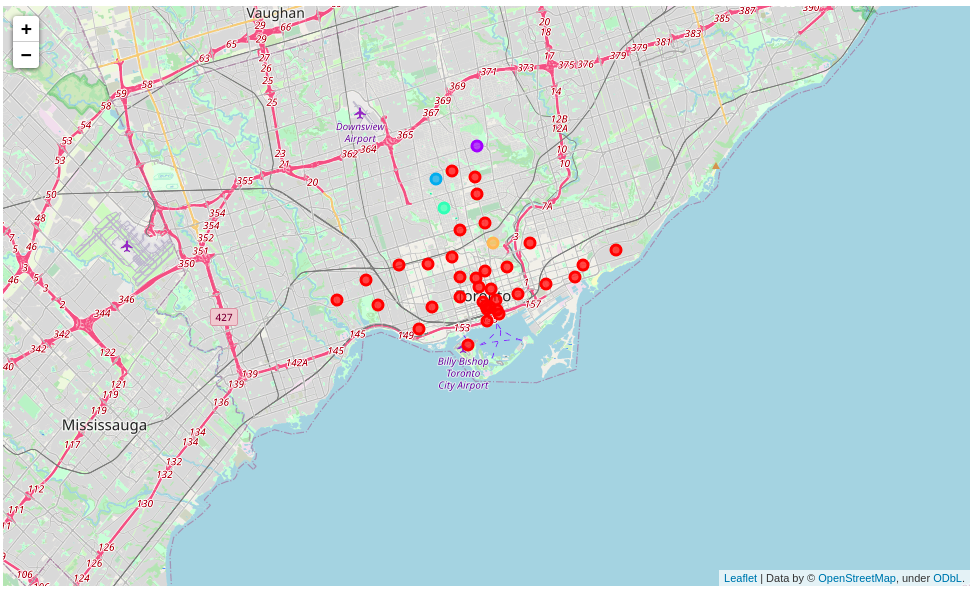

In [26]:
Image("map_toronto.png")

# 3. Analyzing Data New York City, USA

## 3.1 Download and Explore Dataset

In [30]:
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
#print('Data downloaded!')

Data downloaded!


Next, let's load the data.

In [31]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [32]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [33]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [34]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [35]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
dataset_newyork = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [36]:
dataset_newyork

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Then let's loop through the data and fill the dataframe one row at a time.

In [37]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    dataset_newyork = dataset_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [38]:
dataset_newyork.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [39]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(dataset_newyork['Borough'].unique()),
        dataset_newyork.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [40]:
from geopy.geocoders import Nominatim

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## 3.2 Exploring and clustering the neighborhoods in New York City

Creating a map of New York with neighborhoods superimposed on top.

In [41]:
# create map of New York using latitude and longitude values
import folium
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dataset_newyork['Latitude'], dataset_newyork['Longitude'], dataset_newyork['Borough'], dataset_newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

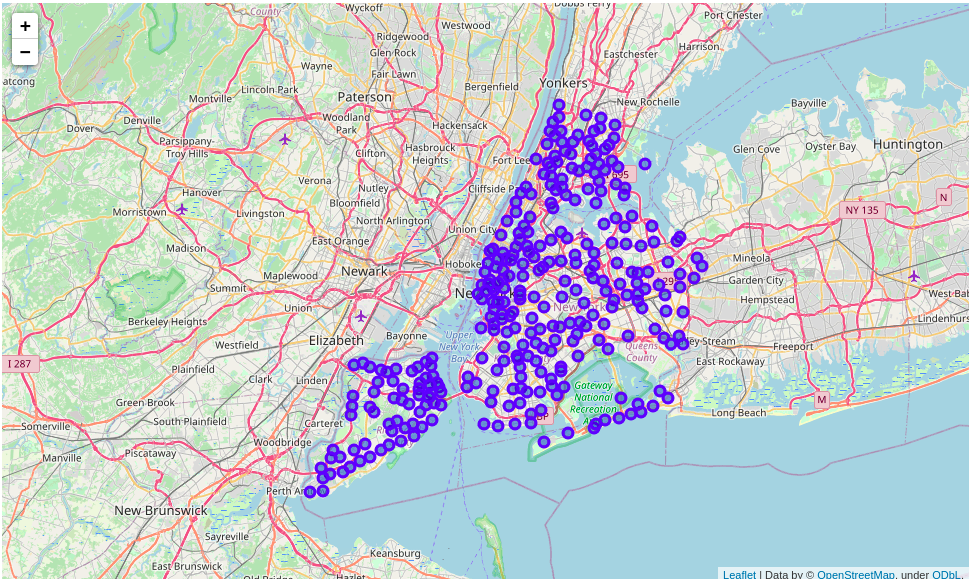

In [42]:
Image("new_york_map_0.png")

In [45]:
LIMIT = 30 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
newyork_venues = getNearbyVenues(names=dataset_newyork['Neighborhood'],
                                 latitudes=dataset_newyork['Latitude'],
                                 longitudes=dataset_newyork['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

Let's check the size of the resulting dataframe

In [46]:
print(newyork_venues.shape)
newyork_venues.head()

(6097, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

Let's check how many venues were returned for each neighborhood

In [47]:
newyork_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                          
Allerton                          27                      27     27   
Annadale                           8                       8      8   
Arden Heights                      4                       4      4   
Arlington                          5                       5      5   
Arrochar                          19                      19     19   
...                              ...                     ...    ...   
Woodhaven                         25                      25     25   
Woodlawn                          24                      24     24   
Woodrow                           20                      20     20   
Woodside                          30                      30     30   
Yorkville                         30                      30     30   

               Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                    
Allerton                   27               27              27  
Annadale                    8                8               8  
Arden Heights               4                4               4  
Arlington                   5                5               5  
Arrochar                   19               19              19  
...                       ...              ...             ...  
Woodhaven                  25               25              25  
Woodlawn                   24               24              24  
Woodrow                    20               20              20  
Woodside                   30               30              30  
Yorkville                  30               30              30  

[300 rows x 6 columns]

### 3.3.1 Analyzing Each Neighborhood

In [48]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

print(newyork_onehot.shape)
newyork_onehot.head()

(6097, 382)


Yoga Studio  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  Arepa Restaurant  ...  Vietnamese Restaurant  Warehouse Store  \
0       0                 0  ...                      0                0   
1       0                 0  ...                      0                0   
2       0                 0  ...                      0                0   
3       0                 0  ...                      0                0   
4       0                 0  ...                      0                0   

   Waste Facility  Waterfront  Weight Loss Center  Whisky Bar  Wine Bar  \
0               0           0                   0           0         0   
1               0           0                   0           0         0   
2               0           0                   0           0         0   
3               0           0                   0           0         0   
4               0           0                   0           0         0   

   Wine Shop  Wings Joint  Women's Store  
0          0            0              0  
1          0            0              0  
2          0            0              0  
3          0            0              0  
4          0            0              0  

[5 rows x 382 columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [49]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

Neighborhood  Yoga Studio  Accessories Store  Adult Boutique  \
0         Allerton          0.0                0.0             0.0   
1         Annadale          0.0                0.0             0.0   
2    Arden Heights          0.0                0.0             0.0   
3        Arlington          0.0                0.0             0.0   
4         Arrochar          0.0                0.0             0.0   
..             ...          ...                ...             ...   
295      Woodhaven          0.0                0.0             0.0   
296       Woodlawn          0.0                0.0             0.0   
297        Woodrow          0.0                0.0             0.0   
298       Woodside          0.0                0.0             0.0   
299      Yorkville          0.0                0.0             0.0   

     Afghan Restaurant  African Restaurant  Airport Terminal  \
0                  0.0                 0.0               0.0   
1                  0.0                 0.0               0.0   
2                  0.0                 0.0               0.0   
3                  0.0                 0.0               0.0   
4                  0.0                 0.0               0.0   
..                 ...                 ...               ...   
295                0.0                 0.0               0.0   
296                0.0                 0.0               0.0   
297                0.0                 0.0               0.0   
298                0.0                 0.0               0.0   
299                0.0                 0.0               0.0   

     American Restaurant  Antique Shop  Arcade  ...  Vietnamese Restaurant  \
0               0.000000           0.0     0.0  ...               0.000000   
1               0.000000           0.0     0.0  ...               0.000000   
2               0.000000           0.0     0.0  ...               0.000000   
3               0.000000           0.0     0.0  ...               0.000000   
4               0.000000           0.0     0.0  ...               0.000000   
..                   ...           ...     ...  ...                    ...   
295             0.000000           0.0     0.0  ...               0.000000   
296             0.041667           0.0     0.0  ...               0.000000   
297             0.000000           0.0     0.0  ...               0.000000   
298             0.100000           0.0     0.0  ...               0.000000   
299             0.000000           0.0     0.0  ...               0.033333   

     Warehouse Store  Waste Facility  Waterfront  Weight Loss Center  \
0                0.0             0.0         0.0                 0.0   
1                0.0             0.0         0.0                 0.0   
2                0.0             0.0         0.0                 0.0   
3                0.0             0.0         0.0                 0.0   
4                0.0             0.0         0.0                 0.0   
..               ...             ...         ...                 ...   
295              0.0             0.0         0.0                 0.0   
296              0.0             0.0         0.0                 0.0   
297              0.0             0.0         0.0                 0.0   
298              0.0             0.0         0.0                 0.0   
299              0.0             0.0         0.0                 0.0   

     Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  
0           0.0  0.000000   0.000000          0.0            0.0  
1           0.0  0.000000   0.000000          0.0            0.0  
2           0.0  0.000000   0.000000          0.0            0.0  
3           0.0  0.000000   0.000000          0.0            0.0  
4           0.0  0.000000   0.000000          0.0            0.0  
..          ...       ...        ...          ...            ...  
295         0.0  0.000000   0.000000          0.0            0.0  
296         0.0  0.000000   0.000000          0.0         

Let's print each neighborhood along with the top 5 most common venues.

In [50]:
num_top_venues = 5

for hood in newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                  venue  freq
0           Pizza Place  0.15
1         Deli / Bodega  0.07
2           Supermarket  0.07
3           Gas Station  0.04
4  Fast Food Restaurant  0.04


----Annadale----
           venue  freq
0    Pizza Place  0.12
1           Food  0.12
2       Pharmacy  0.12
3  Train Station  0.12
4          Diner  0.12


----Arden Heights----
           venue  freq
0    Pizza Place  0.25
1       Pharmacy  0.25
2  Deli / Bodega  0.25
3    Coffee Shop  0.25
4    Yoga Studio  0.00


----Arlington----
           venue  freq
0       Bus Stop   0.4
1  Grocery Store   0.2
2  Deli / Bodega   0.2
3  Boat or Ferry   0.2
4    Yoga Studio   0.0


----Arrochar----
                venue  freq
0            Bus Stop  0.16
1  Italian Restaurant  0.11
2       Deli / Bodega  0.11
3  Athletics & Sports  0.05
4      Cosmetics Shop  0.05


----Arverne----
             venue  freq
0        Surf Spot  0.22
1   Sandwich Place  0.11
2    Metro Station  0.11
3       Board Shop  0

              venue  freq
0    Baseball Field  0.07
1    Discount Store  0.07
2  Basketball Court  0.07
3    Mattress Store  0.07
4              Park  0.07


----Cobble Hill----
                venue  freq
0  Italian Restaurant  0.10
1                 Bar  0.07
2      Ice Cream Shop  0.07
3          Playground  0.07
4        Cocktail Bar  0.07


----College Point----
                       venue  freq
0              Deli / Bodega  0.10
1                     Bakery  0.07
2                Pizza Place  0.07
3  Latin American Restaurant  0.07
4         Chinese Restaurant  0.07


----Concord----
                  venue  freq
0   Peruvian Restaurant  0.11
1    Athletics & Sports  0.11
2  Gym / Fitness Center  0.11
3        Cosmetics Shop  0.11
4         Deli / Bodega  0.11


----Concourse----
                 venue  freq
0        Grocery Store  0.15
1          Pizza Place  0.10
2  Rental Car Location  0.05
3               Bakery  0.05
4       Ice Cream Shop  0.05


----Concourse Village----


            venue  freq
0   Grocery Store  0.08
1          Bakery  0.08
2  Sandwich Place  0.08
3        Pharmacy  0.08
4     Pizza Place  0.04


----Fort Greene----
                     venue  freq
0             Cocktail Bar  0.07
1              Coffee Shop  0.07
2  New American Restaurant  0.07
3               Playground  0.07
4              Flower Shop  0.07


----Fort Hamilton----
                  venue  freq
0   Japanese Restaurant  0.07
1                   Pub  0.07
2    Italian Restaurant  0.07
3  Gym / Fitness Center  0.07
4            Steakhouse  0.07


----Fox Hills----
               venue  freq
0           Bus Stop  0.67
1     Sandwich Place  0.33
2        Yoga Studio  0.00
3  Other Repair Shop  0.00
4               Park  0.00


----Fresh Meadows----
                venue  freq
0         Bus Station  0.21
1  Chinese Restaurant  0.14
2            Pharmacy  0.14
3       Grocery Store  0.07
4        Home Service  0.07


----Fulton Ferry----
            venue  freq
0          

              venue  freq
0               Gym  0.10
1      Burger Joint  0.07
2   Thai Restaurant  0.07
3     Women's Store  0.03
4  Czech Restaurant  0.03


----Lighthouse Hill----
                venue  freq
0  Italian Restaurant   0.2
1               Trail   0.2
2                 Spa   0.2
3          Art Museum   0.2
4                Café   0.2


----Lincoln Square----
                   venue  freq
0                Theater  0.13
1  Performing Arts Venue  0.10
2           Concert Hall  0.10
3    Indie Movie Theater  0.10
4                  Plaza  0.10


----Lindenwood----
                     venue  freq
0              Pizza Place   0.1
1                    Hotel   0.1
2  Fruit & Vegetable Store   0.1
3      Japanese Restaurant   0.1
4                      Gym   0.1


----Little Italy----
                      venue  freq
0            Ice Cream Shop  0.10
1            Sandwich Place  0.10
2  Mediterranean Restaurant  0.07
3           Thai Restaurant  0.07
4                    Bakery

                venue  freq
0         Pizza Place  0.13
1  Chinese Restaurant  0.10
2                Park  0.10
3                Bank  0.10
4       Deli / Bodega  0.07


----Oakland Gardens----
                venue  freq
0   Korean Restaurant  0.11
1  Chinese Restaurant  0.11
2         Yoga Studio  0.07
3                Bank  0.07
4       Jewelry Store  0.04


----Oakwood----
                   venue  freq
0                 Lawyer  0.33
1            Bus Station  0.33
2                    Bar  0.33
3            Yoga Studio  0.00
4  Outdoors & Recreation  0.00


----Ocean Hill----
                             venue  freq
0                    Deli / Bodega  0.18
1                Convenience Store  0.07
2                         Bus Stop  0.07
3                      Supermarket  0.07
4  Southern / Soul Food Restaurant  0.07


----Ocean Parkway----
               venue  freq
0       Liquor Store  0.10
1         Steakhouse  0.05
2  Food & Drink Shop  0.05
3                Gym  0.05
4      G

                  venue  freq
0  Caribbean Restaurant  0.11
1         Grocery Store  0.11
2                  Bank  0.11
3    Seafood Restaurant  0.06
4    Salon / Barbershop  0.06


----Sandy Ground----
           venue  freq
0   Intersection  0.17
1       Bus Stop  0.17
2    Art Gallery  0.08
3     Playground  0.08
4  Shopping Mall  0.08


----Schuylerville----
                 venue  freq
0          Pizza Place  0.11
1  American Restaurant  0.11
2             Pharmacy  0.11
3                Diner  0.11
4   Mexican Restaurant  0.11


----Sea Gate----
          venue  freq
0  Home Service   0.2
1         Beach   0.2
2   Sports Club   0.2
3   Bus Station   0.2
4           Spa   0.2


----Sheepshead Bay----
                venue  freq
0  Turkish Restaurant  0.11
1        Dessert Shop  0.11
2  Chinese Restaurant  0.07
3      Sandwich Place  0.07
4              Buffet  0.04


----Shore Acres----
                venue  freq
0  Italian Restaurant  0.12
1            Bus Stop  0.12
2        In

                venue  freq
0         Coffee Shop  0.10
1                Bank  0.07
2                 Bar  0.07
3  Italian Restaurant  0.07
4         Music Store  0.07


----West Farms----
         venue  freq
0  Bus Station  0.09
1     Bus Stop  0.09
2         Park  0.09
3     Bus Line  0.05
4   Donut Shop  0.05


----West Village----
          venue  freq
0  Cocktail Bar  0.13
1     Speakeasy  0.07
2        Bakery  0.07
3      Wine Bar  0.07
4  Gourmet Shop  0.07


----Westchester Square----
                  venue  freq
0  Fast Food Restaurant  0.10
1            Donut Shop  0.07
2           Pizza Place  0.07
3        Sandwich Place  0.07
4              Pharmacy  0.07


----Westerleigh----
               venue  freq
0     Clothing Store  0.25
1  Convenience Store  0.25
2             Arcade  0.25
3        Comedy Club  0.25
4        Yoga Studio  0.00


----Whitestone----
             venue  freq
0         Dive Bar   0.2
1  Bubble Tea Shop   0.2
2     Dance Studio   0.2
3    Deli / Bode

In [51]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton    Seafood Restaurant           Coffee Shop   
1       Annadale                  Café             Nightclub   
2  Arden Heights    Light Rail Station           Yoga Studio   
3      Arlington        Airport Lounge       Airport Service   
4       Arrochar           Coffee Shop                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Cocktail Bar              Beer Bar                Museum   
1           Coffee Shop        Breakfast Spot                Bakery   
2         Auto Workshop                  Park            Comic Shop   
3      Airport Terminal      Sculpture Garden              Boutique   
4           Yoga Studio    Seafood Restaurant        Sandwich Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Restaurant                  Café                Bistro   
1             Pet Store     Convenience Store          Climbing Gym   
2           Pizza Place               Butcher         Burrito Place   
3       Harbor / Marina                 Plane         Boat or Ferry   
4       Bubble Tea Shop      Ramen Restaurant            Poke Place   

  9th Most Common Venue      10th Most Common Venue  
0          Liquor Store          Basketball Stadium  
1            Restaurant               Burrito Place  
2            Restaurant                     Brewery  
3    Airport Food Court                     Airport  
4    Chinese Restaurant  Modern European Restaurant

### 3.3.2 Cluster Neighborhood

In [53]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 2, 4, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [54]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = dataset_newyork

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             1.0   
1   Bronx   Co-op City  40.874294 -73.829939             1.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             0.0   
4   Bronx    Riverdale  40.890834 -73.912585             0.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

  10th Most Common Venue  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[1],
        fill=True,
        fill_color=rainbow[1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

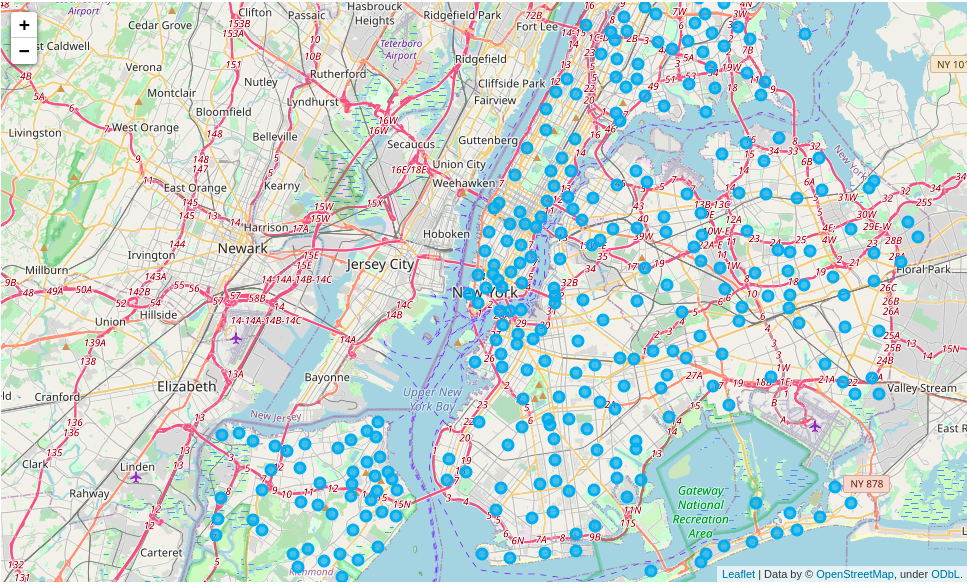

In [64]:
Image("newyork_map_1.png")

# 4. Comparing Toronto and New York City

## 4.1 Comparing number of venues in both cities

In [79]:
print(toronto_venues.shape)
number_of_venues_toronto = toronto_venues.shape[0]
toronto_venues.head()

(868, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront               43.65426              -79.360636   
1  Regent Park, Harbourfront               43.65426              -79.360636   
2  Regent Park, Harbourfront               43.65426              -79.360636   
3  Regent Park, Harbourfront               43.65426              -79.360636   
4  Regent Park, Harbourfront               43.65426              -79.360636   

                    Venue  Venue Latitude  Venue Longitude  \
0        Roselle Desserts       43.653447       -79.362017   
1           Tandem Coffee       43.653559       -79.361809   
2      Morning Glory Cafe       43.653947       -79.361149   
3  Cooper Koo Family YMCA       43.653249       -79.358008   
4     Body Blitz Spa East       43.654735       -79.359874   

        Venue Category  
0               Bakery  
1          Coffee Shop  
2       Breakfast Spot  
3  Distribution Center  
4                  Spa

In [78]:
print(newyork_venues.shape)
number_of_venues_newyork = newyork_venues.shape[0]
newyork_venues.head()

(6097, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

New York city has  6097 venus while Toronto has 868 venues.

## 4.2 Comparing the common venues categories in both cities

In the cells below you can see the number of venues per category in both Toronto and New york cities.

In [94]:
toronto_venues_by_category = toronto_venues.groupby('Venue Category').count()
toronto_venues_by_category

Neighborhood  Neighborhood Latitude  \
Venue Category                                               
Airport                           1                      1   
Airport Food Court                1                      1   
Airport Lounge                    2                      2   
Airport Service                   2                      2   
Airport Terminal                  2                      2   
...                             ...                    ...   
Video Game Store                  1                      1   
Vietnamese Restaurant             4                      4   
Wine Bar                          3                      3   
Wings Joint                       1                      1   
Yoga Studio                       9                      9   

                       Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                         
Airport                                     1      1               1   
Airport Food Court                          1      1               1   
Airport Lounge                              2      2               2   
Airport Service                             2      2               2   
Airport Terminal                            2      2               2   
...                                       ...    ...             ...   
Video Game Store                            1      1               1   
Vietnamese Restaurant                       4      4               4   
Wine Bar                                    3      3               3   
Wings Joint                                 1      1               1   
Yoga Studio                                 9      9               9   

                       Venue Longitude  
Venue Category                          
Airport                              1  
Airport Food Court                   1  
Airport Lounge                       2  
Airport Service                      2  
Airport Terminal                     2  
...                                ...  
Video Game Store                     1  
Vietnamese Restaurant                4  
Wine Bar                             3  
Wings Joint                          1  
Yoga Studio                          9  

[192 rows x 6 columns]

In [95]:
newyork_venues_by_category = newyork_venues.groupby('Venue Category').count()
newyork_venues_by_category

Neighborhood  Neighborhood Latitude  \
Venue Category                                            
Accessories Store              5                      5   
Adult Boutique                 1                      1   
Afghan Restaurant              3                      3   
African Restaurant             4                      4   
Airport Terminal               2                      2   
...                          ...                    ...   
Wine Bar                      27                     27   
Wine Shop                     42                     42   
Wings Joint                    7                      7   
Women's Store                 13                     13   
Yoga Studio                   46                     46   

                    Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                      
Accessories Store                        5      5               5   
Adult Boutique                           1      1               1   
Afghan Restaurant                        3      3               3   
African Restaurant                       4      4               4   
Airport Terminal                         2      2               2   
...                                    ...    ...             ...   
Wine Bar                                27     27              27   
Wine Shop                               42     42              42   
Wings Joint                              7      7               7   
Women's Store                           13     13              13   
Yoga Studio                             46     46              46   

                    Venue Longitude  
Venue Category                       
Accessories Store                 5  
Adult Boutique                    1  
Afghan Restaurant                 3  
African Restaurant                4  
Airport Terminal                  2  
...                             ...  
Wine Bar                         27  
Wine Shop                        42  
Wings Joint                       7  
Women's Store                    13  
Yoga Studio                      46  

[382 rows x 6 columns]

In [97]:
merged_dataset = pd.merge(toronto_venues_by_category, newyork_venues_by_category, on =['Venue Category'], how='inner')
print(merged_dataset.shape)
merged_dataset

(167, 12)


Neighborhood_x  Neighborhood Latitude_x  \
Venue Category                                                   
Airport Terminal                    2                        2   
American Restaurant                 7                        7   
Art Gallery                         8                        8   
Art Museum                          1                        1   
Arts & Crafts Store                 5                        5   
...                               ...                      ...   
Video Game Store                    1                        1   
Vietnamese Restaurant               4                        4   
Wine Bar                            3                        3   
Wings Joint                         1                        1   
Yoga Studio                         9                        9   

                       Neighborhood Longitude_x  Venue_x  Venue Latitude_x  \
Venue Category                                                               
Airport Terminal                              2        2                 2   
American Restaurant                           7        7                 7   
Art Gallery                                   8        8                 8   
Art Museum                                    1        1                 1   
Arts & Crafts Store                           5        5                 5   
...                                         ...      ...               ...   
Video Game Store                              1        1                 1   
Vietnamese Restaurant                         4        4                 4   
Wine Bar                                      3        3                 3   
Wings Joint                                   1        1                 1   
Yoga Studio                                   9        9                 9   

                       Venue Longitude_x  Neighborhood_y  \
Venue Category                                             
Airport Terminal                       2               2   
American Restaurant                    7             101   
Art Gallery                            8              16   
Art Museum                             1               4   
Arts & Crafts Store                    5               6   
...                                  ...             ...   
Video Game Store                       1              16   
Vietnamese Restaurant                  4              14   
Wine Bar                               3              27   
Wings Joint                            1               7   
Yoga Studio                            9              46   

                       Neighborhood Latitude_y  Neighborhood Longitude_y  \
Venue Category                                                             
Airport Terminal                             2                         2   
American Restaurant                        101                       101   
Art Gallery                                 16                        16   
Art Museum                                   4                         4   
Arts & Crafts Store                          6                         6   
...                                        ...                       ...   
Video Game Store                            16                        16   
Vietnamese Restaurant                       14                        14   
Wine Bar                                    27                        27   
Wings Joint                                  7                         7   
Yoga Studio                                 46                        46   

                       Venue_y  Venue Latitude_y  Venue Longitude_y  
Venue Category                                                       
Airport Terminal             2                 2                  2  
American Restaurant        101               101                101  
Art Gallery                 16                16                 16  
Art Museum                   

 New York and Toronto have 167 venue categories in common. The list of common venue categories are:

In [100]:
merged_dataset.index.values

array(['Airport Terminal', 'American Restaurant', 'Art Gallery',
       'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'BBQ Joint', 'Bagel Shop', 'Bakery', 'Bank',
       'Bar', 'Beer Bar', 'Beer Store', 'Bistro', 'Board Shop',
       'Boat or Ferry', 'Bookstore', 'Boutique', 'Breakfast Spot',
       'Brewery', 'Bubble Tea Shop', 'Burger Joint', 'Burrito Place',
       'Bus Line', 'Butcher', 'Café', 'Cajun / Creole Restaurant',
       'Candy Store', 'Caribbean Restaurant', 'Cheese Shop',
       'Chinese Restaurant', 'Chocolate Shop', 'Climbing Gym',
       'Clothing Store', 'Cocktail Bar', 'Coffee Shop',
       'College Arts Building', 'Colombian Restaurant',
       'Comfort Food Restaurant', 'Concert Hall', 'Convenience Store',
       'Cosmetics Shop', 'Creperie', 'Cuban Restaurant', 'Dance Studio',
       'Deli / Bodega', 'Department Store', 'Dessert Shop', 'Diner',
       'Discount Store', 'Dog Run', 'Donut Shop',
       'Eastern European Resta

## 4.3 Comparing the common venues in both cities

In [102]:
toronto_venues_by_venue = toronto_venues.groupby('Venue').count()
toronto_venues_by_venue

Neighborhood  Neighborhood Latitude  \
Venue                                                                  
241 Pizza                                   1                      1   
306 Yonge Street - Jordan Store             1                      1   
401 Games                                   2                      2   
7 Numbers                                   1                      1   
A & C Games                                 1                      1   
...                                       ...                    ...   
famous last words                           1                      1   
iQ Food Co                                  1                      1   
lululemon                                   1                      1   
nodo                                        1                      1   
souvlaki express                            1                      1   

                                 Neighborhood Longitude  Venue Latitude  \
Venue                                                                     
241 Pizza                                             1               1   
306 Yonge Street - Jordan Store                       1               1   
401 Games                                             2               2   
7 Numbers                                             1               1   
A & C Games                                           1               1   
...                                                 ...             ...   
famous last words                                     1               1   
iQ Food Co                                            1               1   
lululemon                                             1               1   
nodo                                                  1               1   
souvlaki express                                      1               1   

                                 Venue Longitude  Venue Category  
Venue                                                             
241 Pizza                                      1               1  
306 Yonge Street - Jordan Store                1               1  
401 Games                                      2               2  
7 Numbers                                      1               1  
A & C Games                                    1               1  
...                                          ...             ...  
famous last words                              1               1  
iQ Food Co                                     1               1  
lululemon                                      1               1  
nodo                                           1               1  
souvlaki express                               1               1  

[685 rows x 6 columns]

In [103]:
newyork_venues_by_venue = newyork_venues.groupby('Venue').count()
newyork_venues_by_venue

Neighborhood  \
Venue                                                              
1 Hotel Brooklyn Bridge                                        1   
1 Rooftop                                                      1   
1 Stop Grocery & Candy Store                                   1   
1001 Nights Cafe                                               1   
101 Deli                                                       1   
...                                                          ...   
ØDD. New York                                                  1   
重庆老灶 (Chong Qing Lao Zao)                                      1   
돌아온 1.5 닭갈비                                                    1   
병천자매순대 (Byun Chung Soon Dae Restaurant) (Byun C...             1   
큰손 칼국수                                                         1   

                                                    Neighborhood Latitude  \
Venue                                                                       
1 Hotel Brooklyn Bridge                                                 1   
1 Rooftop                                                               1   
1 Stop Grocery & Candy Store                                            1   
1001 Nights Cafe                                                        1   
101 Deli                                                                1   
...                                                                   ...   
ØDD. New York                                                           1   
重庆老灶 (Chong Qing Lao Zao)                                               1   
돌아온 1.5 닭갈비                                                             1   
병천자매순대 (Byun Chung Soon Dae Restaurant) (Byun C...                      1   
큰손 칼국수                                                                  1   

                                                    Neighborhood Longitude  \
Venue                                                                        
1 Hotel Brooklyn Bridge                                                  1   
1 Rooftop                                                                1   
1 Stop Grocery & Candy Store                                             1   
1001 Nights Cafe                                                         1   
101 Deli                                                                 1   
...                                                                    ...   
ØDD. New York                                                            1   
重庆老灶 (Chong Qing Lao Zao)                                                1   
돌아온 1.5 닭갈비                                                              1   
병천자매순대 (Byun Chung Soon Dae Restaurant) (Byun C...                       1   
큰손 칼국수                                                                   1   

                                                    Venue Latitude  \
Venue                                                                
1 Hotel Brooklyn Bridge                                          1   
1 Rooftop                                                        1   
1 Stop Grocery & Candy Store                                     1   
1001 Nights Cafe                                                 1   
101 Deli                                                         1   
...                                                            ...   
ØDD. New York                                                    1   
重庆老灶 (Chong Qing Lao Zao)                                        1   
돌아온 1.5 닭갈비                                                      1   
병천자매순대 (Byun Chung Soon Dae Restaurant) (Byun C...               1   
큰손 칼국수                                                           1   

                                                    Venue Longitude  \
Venue                                                                 
1 Hotel Brooklyn Bridge                                           1   
1 Rooftop                 

In [104]:
merged_dataset = pd.merge(toronto_venues_by_venue, newyork_venues_by_venue, on =['Venue'], how='inner')
print(merged_dataset.shape)
merged_dataset

(10, 12)


Neighborhood_x  Neighborhood Latitude_x  \
Venue                                                                
Chipotle Mexican Grill                  1                        1   
Five Guys                               1                        1   
GAP                                     1                        1   
Hole in the Wall                        1                        1   
KFC                                     1                        1   
Popeyes Louisiana Kitchen               1                        1   
Positano                                1                        1   
Starbucks                              14                       14   
Subway                                  7                        7   
Tim Hortons                             8                        8   

                           Neighborhood Longitude_x  Venue Latitude_x  \
Venue                                                                   
Chipotle Mexican Grill                            1                 1   
Five Guys                                         1                 1   
GAP                                               1                 1   
Hole in the Wall                                  1                 1   
KFC                                               1                 1   
Popeyes Louisiana Kitchen                         1                 1   
Positano                                          1                 1   
Starbucks                                        14                14   
Subway                                            7                 7   
Tim Hortons                                       8                 8   

                           Venue Longitude_x  Venue Category_x  \
Venue                                                            
Chipotle Mexican Grill                     1                 1   
Five Guys                                  1                 1   
GAP                                        1                 1   
Hole in the Wall                           1                 1   
KFC                                        1                 1   
Popeyes Louisiana Kitchen                  1                 1   
Positano                                   1                 1   
Starbucks                                 14                14   
Subway                                     7                 7   
Tim Hortons                                8                 8   

                           Neighborhood_y  Neighborhood Latitude_y  \
Venue                                                                
Chipotle Mexican Grill                 11                       11   
Five Guys                               2                        2   
GAP                                     1                        1   
Hole in the Wall                        1                        1   
KFC                                     8                        8   
Popeyes Louisiana Kitchen              28                       28   
Positano                                1                        1   
Starbucks                              26                       26   
Subway                                 51                       51   
Tim Hortons                             1                        1   

                           Neighborhood Longitude_y  Venue Latitude_y  \
Venue                                                                   
Chipotle Mexican Grill                           11                11   
Five Guys                                         2                 2   
GAP                                               1                 1   
Hole in the Wall                                  1                 1   
KFC                                               8                 8   
Popeyes Louisiana Kitchen                        28                28   
Positano                                          1                 1   
Starbucks         

New York and Toronto have 10 venues in common. The first intuituion is that the would have more venues in common, the first intuituion was proven wron. The list of common venue categories are:

In [106]:
merged_dataset.index.values

array(['Chipotle Mexican Grill', 'Five Guys', 'GAP', 'Hole in the Wall',
       'KFC', 'Popeyes Louisiana Kitchen', 'Positano', 'Starbucks',
       'Subway', 'Tim Hortons'], dtype=object)